In [1]:
from os.path import join
import pandas as pd
import numpy as np
import gzip
import json
import time
import scipy.spatial
import pickle

from sklearn.feature_extraction import DictVectorizer
from keras.preprocessing.text import text_to_word_sequence

Using TensorFlow backend.
/home/michael/Documents/deep_learning/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# utils
def init_embedding_map(fileName):
    print("initializing embeddings")
    with open(join("data", "glove.6B", fileName)) as glove:
        return {l[0]: np.asarray(l[1:], dtype="float32") for l in [line.split() for line in glove]}

def clean(text):
    return text_to_word_sequence(text, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                                 lower=True, split=" ")


# returns dict with users and movies they rated as repeated rows
# cleans review text and add to rawOutput
def init_raw_data(input_file):
    print("initializing raw data")
    rawInputData = []
    rawOutputData = []
    with open(input_file,"r") as f:
        for i in f:
            line = f.readline()
            if len(line) < 4:
                break
            lineObj = json.loads(line)
            user = lineObj["reviewerID"]
            item = lineObj["asin"]
            rawInputDataObj = {"user": user, "asin": item}
            rawOutputDataObj = clean(lineObj["reviewText"])
            rawInputData.append(rawInputDataObj)
            rawOutputData.append(rawOutputDataObj)
    return rawInputData, rawOutputData

# creates dict of usrs w/ all movies rated + movies w/ all user ratings *** 
def group_data(inputData):
    users = {}
    items = {}
    for datum in inputData:
        u = datum["user"]
        i = datum["asin"]
        users.setdefault(u, []).append(i)
        items.setdefault(i, []).append(u)
    return users, items

def get_set_from_data(key, data):
    return set([datum.get(key) for datum in data])

def seq_2_matrix(sequence, embedding_map):
    return np.array([embedding_map.get(word) for word in sequence if word in embedding_map])

def matrix_2_avg(emb_matrix):
    return np.mean(emb_matrix, 0)


# utils - one hot encodes all data 
def init_vec_data(rawInputData, rawOutputData, embedding_map):
    print('initializing vectorized data')
    dictVect = DictVectorizer()
    vecInputData = dictVect.fit_transform(rawInputData).toarray()
    vecOutputData = [matrix_2_avg(seq_2_matrix(review, embedding_map)) for review in rawOutputData]
    return vecInputData, vecOutputData

def init_mat_input_data(rawInputData, rawOutputData, embedding_map, save=False):
    print('initializing matrix data')
    if len(rawInputData) != len(rawOutputData):
        raise ValueError("Need same size of input and output")
    users = {}
    extra_info = {}
    items = {}
    dictVect = DictVectorizer()
    for i in range(len(rawInputData)):
        vecOutput = seq_2_matrix(rawOutputData[i], embedding_map)
        rawInput = rawInputData[i]
        user = rawInput['user']
        item = rawInput['asin']
        users.setdefault(user, []).append(vecOutput)
        items.setdefault(item, []).append(vecOutput)
        
    matUserInputData = []
    matItemInputData = []
    users = {k: np.vstack(v) for k, v in users.items()}
    items = {k: np.vstack(v) for k, v in items.items()}
    extra_info['user_seq_sizes'] = [m.shape[0] for m in users.values()]
    extra_info['item_seq_sizes'] = [m.shape[0] for m in items.values()]
    for i in range(len(rawInputData)):
        rawInput = rawInputData[i]
        user = rawInput['user']
        item = rawInput['asin']
        matUserInputData.append(users.get(user))
        matItemInputData.append(items.get(item))
    return matUserInputData, matItemInputData, extra_info

def to_key(user, item):
    return (user, item)

def init_ratings_output_data(rawInputData, input_file, save=False):
    ratingsData = []
    userItemDict = {}
    for i in range(len(rawInputData)):
        rawInput = rawInputData[i]
        userItem = toKey(rawInput['user'], rawInput['asin'])
        userItemDict[userItem] = i
        ratingsData.append(None) # check later to make sure no Nones left
        
    with open(input_file,'r') as f:
        for i in f:
            line = f.readline()
            lineObj = json.loads(line)
            user = lineObj['reviewerID']
            item = lineObj['asin']
            rating = lineObj['overall']
            i = userItemDict.get(toKey(user, item))
            if i is not None:
                ratingsData[i] = rating
        failure = None in ratingsData
        if failure:
            raise ValueError(str(len([r for r in ratingsData if r is None])) + " reviews did not have corresponding rating.")
    return ratingsData

In [7]:
fileName = "data/reviews_Amazon_Instant_Video_5.json"
raw_input_data, raw_output_data = init_raw_data(input_file=fileName)
rand_idxs = np.random.permutation(len(raw_output_data))
raw_input_data = [raw_input_data[i] for i in rand_idxs]
raw_output_data = [raw_output_data[i] for i in rand_idxs]
embedding_map = init_embedding_map("glove.6B.50d.txt")
all_users = get_set_from_data('user', raw_input_data)
all_movies = get_set_from_data('asin', raw_input_data)
vec_input_data, vec_output_data = init_vec_data(raw_input_data, raw_output_data, embedding_map)
mat_user_input_data, mat_movie_input_data, extra_info = init_mat_input_data(vec_input_data, vec_output_data, embedding_map)
file_name = "data/reviews_Amazon_Instant_Video_5.json"
ratings_data = init_ratings_outputData(raw_input_data, input_file=fileName,save=False)

initializing raw data
initializing embeddings
initializing vectorized data
initializing matrix data


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# DeepCoNN Recommendation Model - Pretrained Embeddings

In [12]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers.merge import Dot
from keras.callbacks import EarlyStopping
from keras import metrics
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers.merge import Add, Dot, Concatenate
from keras.preprocessing.sequence import pad_sequences

In [13]:
class DeepCoNN():
    def __init__(self, embedding_size, hidden_size, u_seq_len, m_seq_len, filters=2, kernel_size=8, strides=6):
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.filters = filters
        self.kernel_size = kernel_size
        self.inputU, self.towerU = self.create_deepconn_tower(u_seq_len)
        self.inputM, self.towerM = self.create_deepconn_tower(m_seq_len)
        self.joined = Concatenate()([self.towerU, self.towerM])
        self.outNeuron = Dense(1)(self.joined)

    def create_deepconn_tower(self, max_seq_len):
        input_layer = Input(shape=(max_seq_len, self.embedding_size))
        tower = Conv1D(filters=self.filters, kernel_size=self.kernel_size, activation="relu")(input_layer)
        tower = MaxPooling1D()(tower)
        tower = Flatten()(tower)
        tower = Dense(self.hidden_size, activation="relu")(tower)
        return input_layer, tower

    def create_deepconn_dp(self):
        dotproduct = Dot(axes=1)([self.towerU, self.towerM])
        output = Add()([self.outNeuron, dotproduct])
        model = Model(inputs=[self.inputU, self.inputM], outputs=[output])
        model.compile(optimizer='Adam', loss='mse')
        return model

In [15]:
def build_DeepcoNN(matUserInputData, matItemInputData, ratingsData, u_seq_len=200, i_seq_len=200, hidden_size=4, epochs=3500, training=None):
    embed_dims = matUserInputData[0].shape[1]
    deepconn = DeepCoNN(embed_dims, hidden_size, u_seq_len, i_seq_len)

    model = deepconn.create_deepconn_dp()

    user_input = pad_sequences(np.asarray(matUserInputData), maxlen=u_seq_len)
    item_input = pad_sequences(np.asarray(matItemInputData), maxlen=i_seq_len)

    trainingN = int(len(user_input) * training) if type(training) is float else training

    inputs = [user_input, item_input]
    outputs = np.asarray(ratingsData)
    print(model.summary())

    train_inputs = [user_input[:trainingN], item_input[:trainingN]]
    train_outputs = outputs[:trainingN]
    test_inputs = [user_input[trainingN:], item_input[trainingN:]]
    test_outputs = outputs[trainingN:]

    early_stopping = EarlyStopping(monitor='loss', patience=4)
    early_stopping_val = EarlyStopping(monitor='val_loss', patience=6)
    batch_size = 32
    history = model.fit(train_inputs, train_outputs, validation_split=0.01, callbacks=[early_stopping, early_stopping_val], batch_size=batch_size, epochs=epochs)
    return history

In [16]:
# Calculates median user review length and item length. We then pad each review to these numbers
histories = []
for i in range(50, 20, -5):
    ptile = i
    u_seq_len = int(np.percentile(np.array(extra_info['user_seq_sizes']), ptile))
    i_seq_len = int(np.percentile(np.array(extra_info['item_seq_sizes']), ptile))
    histories.append(build_DeepcoNN(matUserInputData, matMovieInputData, ratingsData, 
                   u_seq_len=u_seq_len, i_seq_len=i_seq_len, hidden_size=4, 
                   epochs=10, training=None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 141, 50)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 474, 50)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 134, 2)       802         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 467, 2)       802         input_2[0][0]                    
__________________________________________________________________________________________________
max_poolin

MemoryError: 

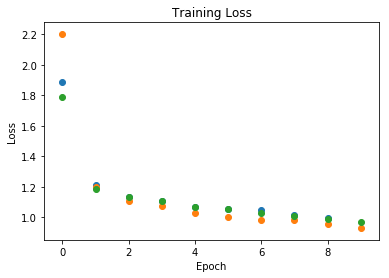

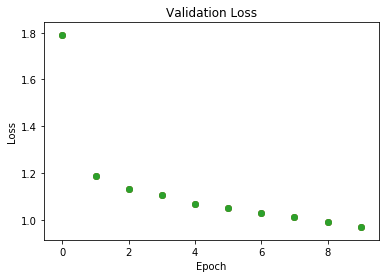

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def graph_loss(loss_arr, title):
    plt.scatter(x=range(len(loss)), y=loss)
for history in histories:
    loss = history.history["loss"]
    graph_loss(loss, "Training Loss")

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()